## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

import warnings
warnings.filterwarnings('ignore')

## reading the dataset

In [2]:
df = pd.read_excel('../data/dataset.xlsx')

## EDA - exploratory data analysis

In [32]:
df.head()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,33.8,11.1,4.18,4.6,150,26.6,32.8,80.9,33,F,1
1,44.6,14.0,6.86,6.3,232,20.4,31.4,65.0,36,M,0
2,42.9,14.0,4.57,6.2,336,30.6,32.6,93.9,70,F,0
3,41.9,14.4,4.67,3.5,276,30.8,34.4,89.7,18,F,0
4,40.6,13.3,4.85,14.9,711,27.4,32.8,83.7,36,M,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3309 entries, 0 to 3308
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HAEMATOCRIT   3309 non-null   float64
 1   HAEMOGLOBINS  3309 non-null   float64
 2   ERYTHROCYTE   3309 non-null   float64
 3   LEUCOCYTE     3309 non-null   float64
 4   THROMBOCYTE   3309 non-null   int64  
 5   MCH           3309 non-null   float64
 6   MCHC          3309 non-null   float64
 7   MCV           3309 non-null   float64
 8   AGE           3309 non-null   int64  
 9   SEX           3309 non-null   object 
 10  SOURCE        3309 non-null   int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 284.5+ KB


In [5]:
df.duplicated().sum()

0

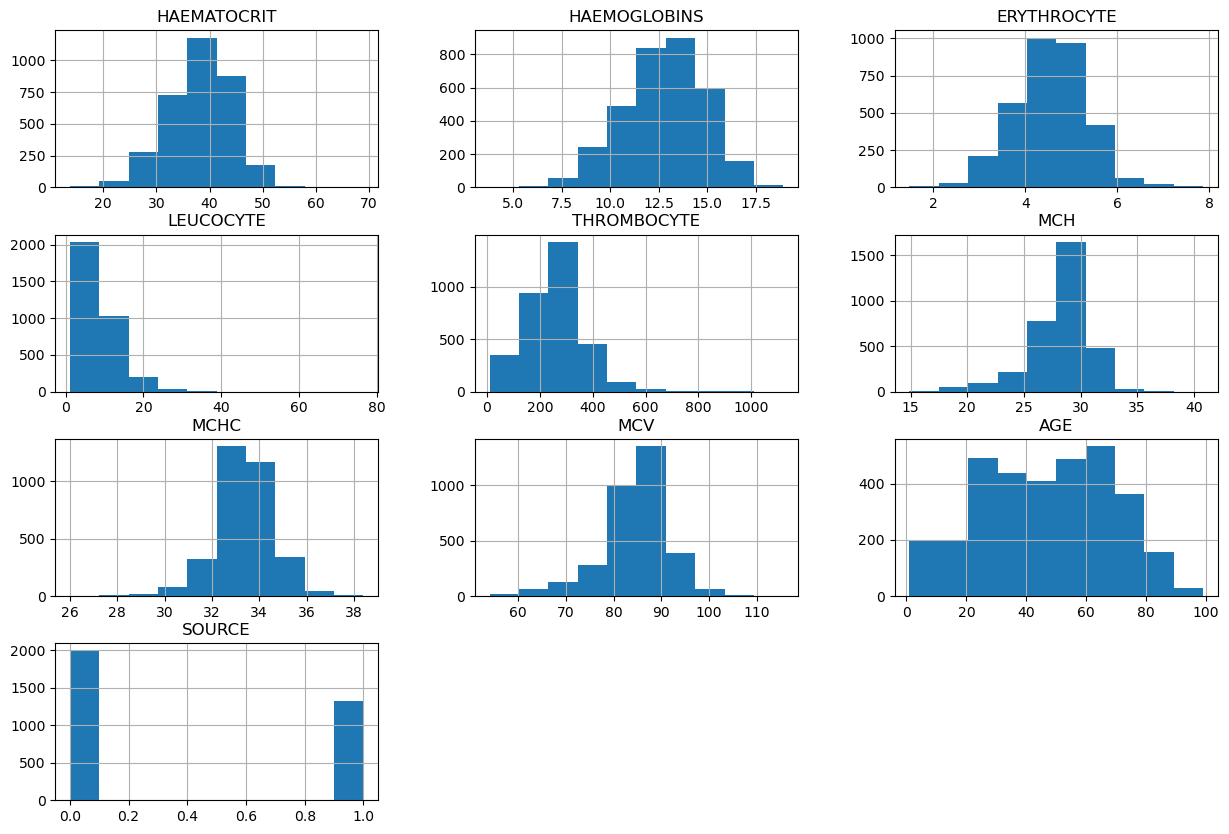

In [6]:
# Histogram plot of the dataset df
df.hist(figsize=(15, 10))
plt.show()

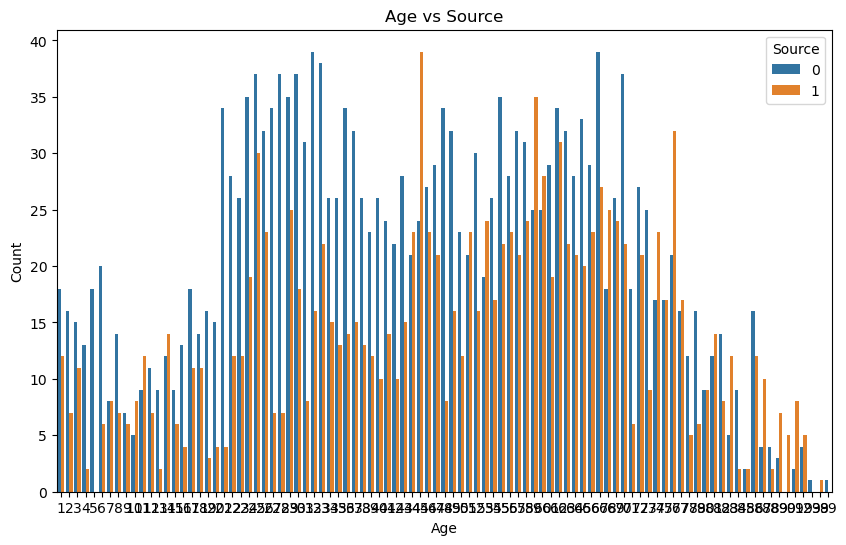

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='AGE', hue='SOURCE', data=df)
plt.title('Age vs Source')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Source')
plt.show()

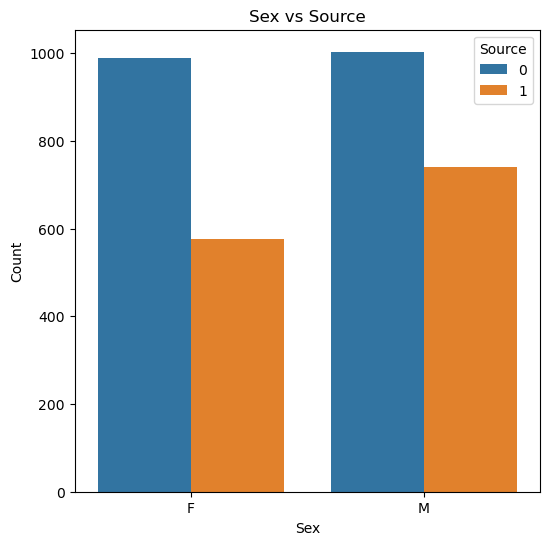

In [8]:
plt.figure(figsize=(6, 6))
sns.countplot(x='SEX', hue='SOURCE', data=df)
plt.title('Sex vs Source')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Source')
plt.show()

## Plotting the correlation matrix

In [9]:
corr_mat = df.corr(numeric_only=True)

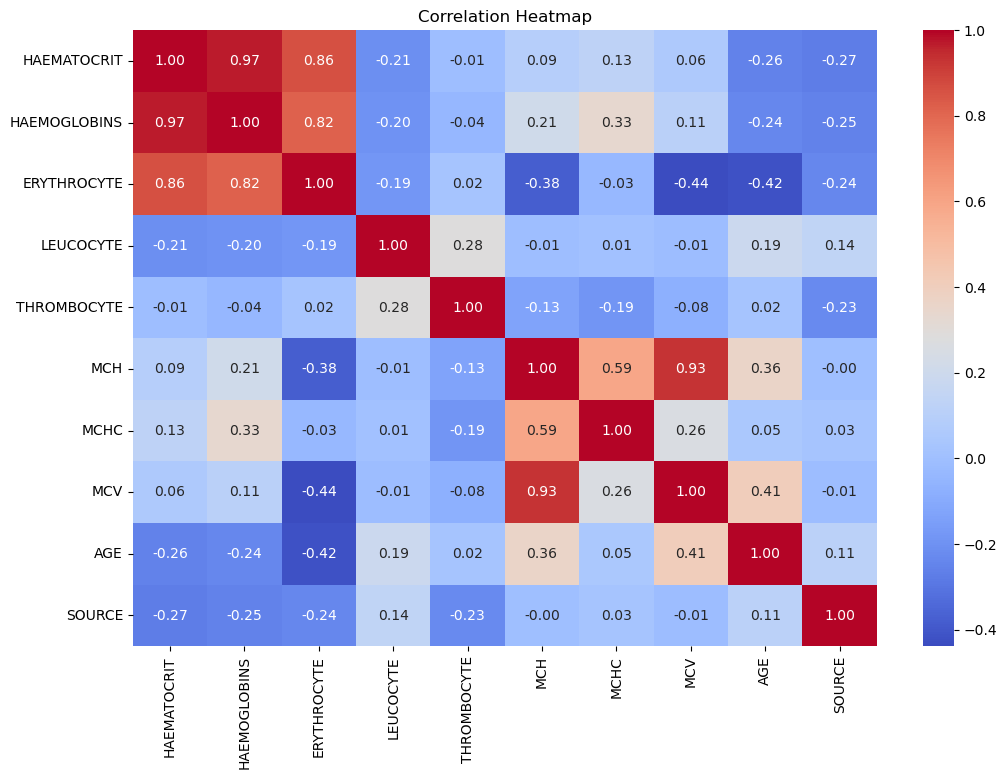

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

## Boxplot to look for outliers

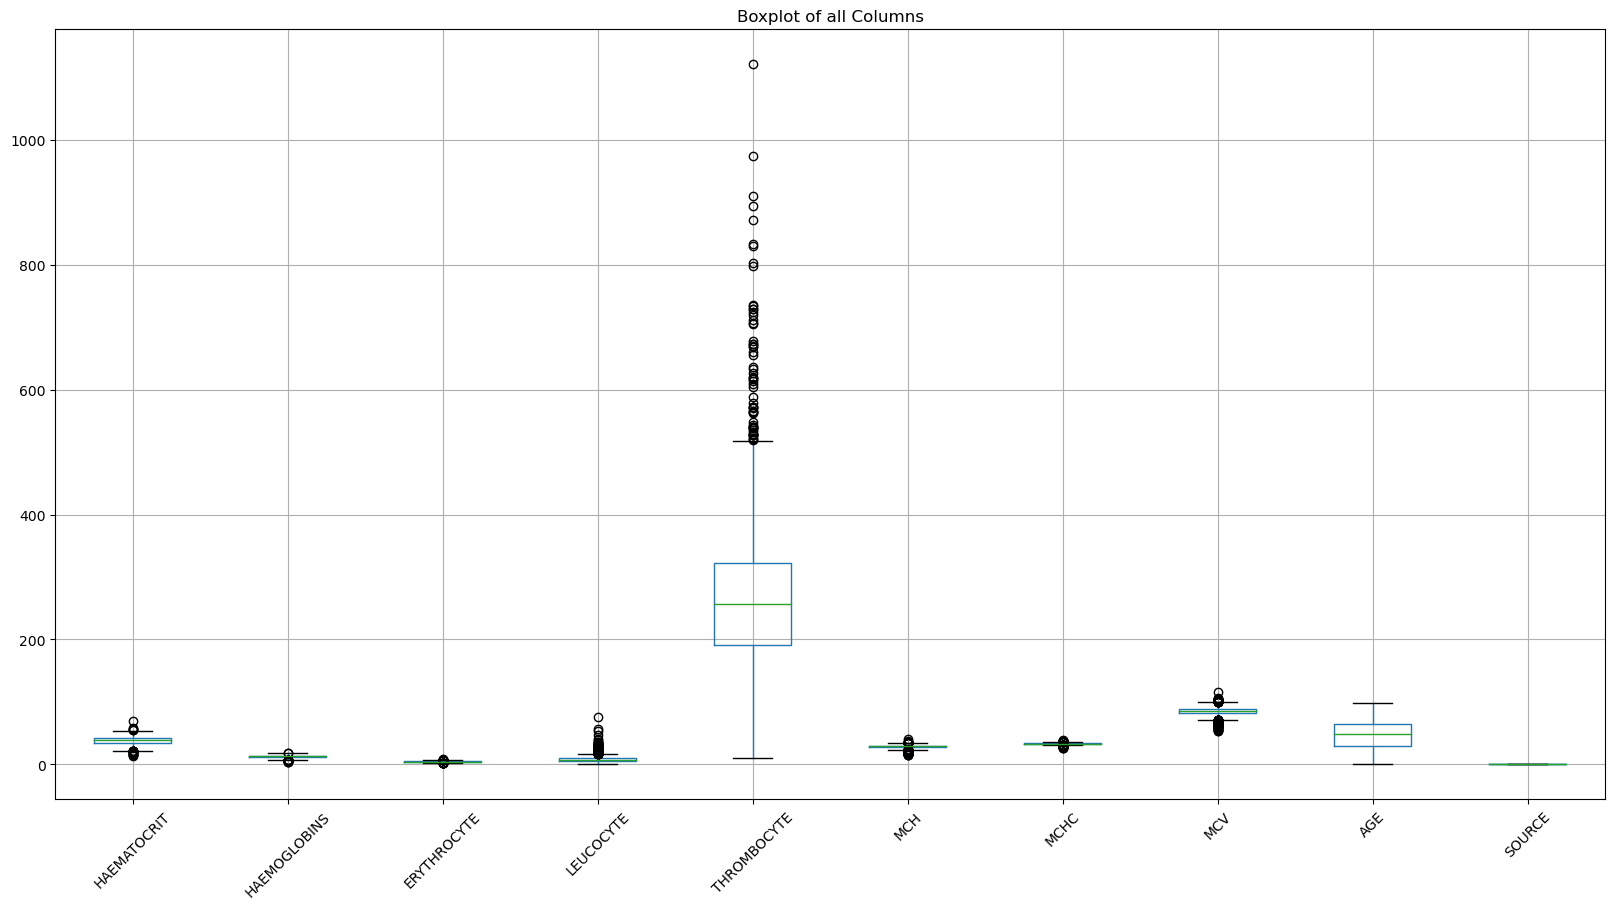

In [11]:
plt.figure(figsize=(20, 10))
df.boxplot()
plt.xticks(rotation=45)
plt.title('Boxplot of all Columns')
plt.show()

In [12]:
numeric_cols = df.select_dtypes(include=['number']).columns
numeric_df = df[numeric_cols]

In [13]:
z_scores = zscore(numeric_df)
outliers = (z_scores > 3) | (z_scores < -3)
outlier_indices = df.index[outliers.any(axis=1)]
outliers_df = df.loc[outlier_indices]

print(outliers_df)

      HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE   MCH  \
4            40.6          13.3         4.85       14.9          711  27.4   
14           35.9          10.4         5.45        8.0          500  19.1   
16           22.0           6.8         2.09       47.7          414  32.5   
18           35.1          10.4         5.20        7.1          254  20.0   
35           31.3          10.3         3.74       30.1          562  27.5   
...           ...           ...          ...        ...          ...   ...   
3248         44.1          14.7         4.67       14.8         1121  31.5   
3253         51.7          16.5         7.57        9.7          279  21.8   
3261         47.4          14.7         7.86        6.1          216  18.7   
3278         32.3          12.0         3.99       16.4          421  30.1   
3298         37.2          11.7         6.18       16.6          336  18.9   

      MCHC    MCV  AGE SEX  SOURCE  
4     32.8   83.7   36   M

In [14]:
num_outliers_df = outliers_df[numeric_cols]

# Iterate over each column in the outliers_df DataFrame
for column in num_outliers_df.columns:
    # Calculate the IQR for the column
    Q1 = num_outliers_df[column].quantile(0.25)
    Q3 = num_outliers_df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Find the outliers using the IQR method
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = num_outliers_df[(num_outliers_df[column] < lower_bound) | (num_outliers_df[column] > upper_bound)]

    # Print the outliers for each column
    if not outliers.empty:
        print(f"Column: {column}")
        print(outliers)

Column: HAEMATOCRIT
      HAEMATOCRIT  HAEMOGLOBINS  ERYTHROCYTE  LEUCOCYTE  THROMBOCYTE   MCH  \
141          58.1          18.9         6.53       30.8          428  28.9   
467          13.7           4.4         1.48        5.3          263  29.7   
663          56.0          15.9         5.40       15.7          263  29.4   
871          53.0          16.3         7.54        4.3          112  21.6   
1487         53.2          17.0         7.35        6.1           12  23.1   
1998         54.0          16.6         7.61       10.0           88  21.8   
2057         57.0          18.8         6.35        5.9          299  29.6   
2108         55.8          17.8         6.75       14.5          637  26.4   
2197         14.5           5.0         1.72        5.0          217  29.1   
2361         14.6           3.8         2.31        5.2          403  16.5   
2822         52.5          17.3         6.90        8.0          211  25.1   
3171         69.0          12.1         4.04

## Outlier treatment

In [15]:
def outlier_treatment(dataframe):
    
    numeric_columns = dataframe.select_dtypes(include=[np.number]).columns
    
    aligned_dataframe = dataframe[numeric_columns].align(dataframe[numeric_columns], axis=1, copy=False)[0]
    
    Q1 = dataframe[numeric_columns].quantile(0.25)
    Q3 = dataframe[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1
    
    outliers = ((aligned_dataframe < (Q1 - 1.5 * IQR)) | (aligned_dataframe > (Q3 + 1.5 * IQR)))
    
    df_rem_out = dataframe[~outliers.any(axis=1)]
    return df_rem_out

dataset = outlier_treatment(df)

In [16]:
dataset.head()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,33.8,11.1,4.18,4.6,150,26.6,32.8,80.9,33,F,1
2,42.9,14.0,4.57,6.2,336,30.6,32.6,93.9,70,F,0
3,41.9,14.4,4.67,3.5,276,30.8,34.4,89.7,18,F,0
5,32.8,11.2,3.94,11.0,324,28.4,34.1,83.2,89,F,0
7,38.4,12.3,4.37,9.0,193,28.1,32.0,87.9,74,M,1


In [17]:
sex_map = {'M': 0, 'F': 1}
dataset['SEX'] = dataset['SEX'].map(sex_map)

In [18]:
dataset.head()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,33.8,11.1,4.18,4.6,150,26.6,32.8,80.9,33,1,1
2,42.9,14.0,4.57,6.2,336,30.6,32.6,93.9,70,1,0
3,41.9,14.4,4.67,3.5,276,30.8,34.4,89.7,18,1,0
5,32.8,11.2,3.94,11.0,324,28.4,34.1,83.2,89,1,0
7,38.4,12.3,4.37,9.0,193,28.1,32.0,87.9,74,0,1


## Feature and Target variables

In [19]:
X = dataset.drop('SOURCE', axis=1)
y = dataset['SOURCE']

## Splitting the training and testing datasets using train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training a Random Forest Classifier model

In [21]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
y_pred = rf_clf.predict(X_test)

In [23]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7629233511586453


In [24]:
clf_report = classification_report(y_test, y_pred)
print(clf_report)

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       348
           1       0.74      0.57      0.65       213

    accuracy                           0.76       561
   macro avg       0.76      0.73      0.73       561
weighted avg       0.76      0.76      0.76       561



In [25]:
cm = confusion_matrix(y_test, y_pred)

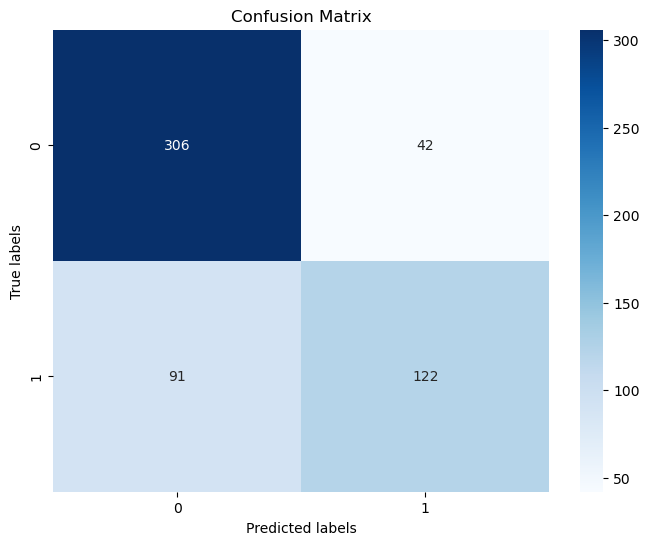

In [26]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [27]:
importances = rf_clf.feature_importances_
feature_names = X.columns

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importance_df)

Feature Importance:
        Feature  Importance
4   THROMBOCYTE    0.221973
3     LEUCOCYTE    0.128340
0   HAEMATOCRIT    0.113343
2   ERYTHROCYTE    0.101623
8           AGE    0.095731
7           MCV    0.087376
1  HAEMOGLOBINS    0.082956
6          MCHC    0.078512
5           MCH    0.071471
9           SEX    0.018675


<Figure size 1000x800 with 0 Axes>

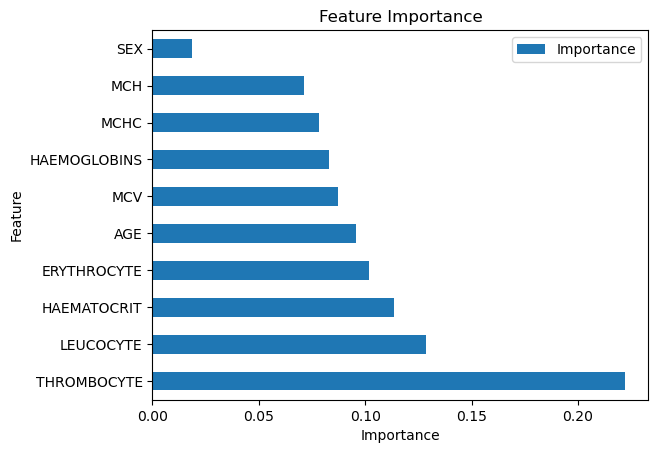

In [28]:
plt.figure(figsize=(10, 8))
feature_importance_df.plot(kind='barh', x='Feature', y='Importance')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Saving the model

In [31]:
joblib.dump(rf_clf, '../models/model.joblib')

['../models/model.joblib']

# Hyperparameter tuning

In [33]:
param_grid = {
    'n_estimators': [10, 50, 100, 150],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

In [34]:
# Creating the GridSearchCV object
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fitting the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   1.3s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [10, 50, 100, 150]},
             scoring='accuracy', verbose=2)

## Training a Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred_lr)
acc_lr = accuracy_score(y_test, y_pred_lr)

In [37]:
# Print confusion matrix and accuracy score
print("Logistic Regression:")
print("Confusion Matrix:")
print(cm_lr)
print("Accuracy:", acc_lr)

Logistic Regression:
Confusion Matrix:
[[309  39]
 [102 111]]
Accuracy: 0.7486631016042781
